## [4주차] 기본과제 - HuggingFace로 두 문장의 논리적 모순 분류하기

MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제이다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.

In [1]:
%pip install transformers datasets numpy matplotlib evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

## Dataset 준비

허깅페이스를 통해 mnli 데이터셋을 로드한다.

- train: 모델 학습을 위한 주 데이터셋으로, 다양한 장르의 텍스트로 구성
- validation_matched: 모델 성능 평가를 위한 검증 데이터셋으로, 학습의 데이터와 같은 장르의 텍스트로 구성된다. 모델이 학습한 도메인에서 얼마나 잘 작동하는지 평가한다.
- validation_mismatched: 모델 성능 평가를 위한 검증 데이터셋으로, 학습 데이터와 다른 장르의 텍스트로 구성된다. 모델이 새로운 도메인에서 얼마나 잘 작동하는지 평가한다.
- test_matched: 최종 테스트용 데이터셋으로, 학습 데이터와 같은 장르의 텍스트로 구성된다.
- test_mismatched: 최종 테스트용 데이터셋으로, 학습 데이터와 다른 장르의 텍스트로 구성된다.

학습에 사용한 train 데이터는 392702개, 검증에 사용한 validation_matched 데이터는 9815개이다.

In [3]:
mnli = load_dataset("nyu-mll/glue", "mnli")
mnli

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [4]:
mnli['train'][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

RoBERTa 토크나이저를 로드하여 데이터셋에 적용한다.

학습에 사용한 데이터셋은 전체의 5%로만 사용한다.

In [5]:
from transformers import AutoTokenizer

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# RoBERTa 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# MNLI 데이터셋을 위한 전처리 함수
def preprocess_function(data):
    return tokenizer(
        data['premise'],
        data['hypothesis'],
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors=None
    )

# 데이터셋 토크나이징
tokenized_mnli = mnli['train'].map(preprocess_function, batched=True)
tokenized_validation_matched = mnli['validation_matched'].map(preprocess_function, batched=True)

# 데이터셋의 5%만 사용
train_size = len(tokenized_mnli) // 20    # 약 19,635개
val_size = len(tokenized_validation_matched) // 20   # 약 490개

train_dataset = tokenized_mnli.shuffle(seed=42).select(range(train_size))
validation_dataset = tokenized_validation_matched.shuffle(seed=42).select(range(val_size))

토크나이징한 결과 input_ids와 attention_mask가 추가된 것을 확인할 수 있다.

In [6]:
tokenized_mnli[0].keys()

dict_keys(['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'])

## Model 정의와 학습

모델을 평가할 메트릭을 정의한다.

In [7]:
from transformers import AutoModelForSequenceClassification
import numpy as np
from evaluate import load

# entailment, contradiction, neutral
num_labels = 3

# RoBERTa 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_labels
)

# 분류기(classifier)를 제외한 모든 레이어 동결
for param in model.roberta.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

accuracy = load("accuracy")

# 평가 메트릭 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = accuracy.compute(predictions=predictions, references=labels)

    return metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


학습할 때 early stopping을 사용하기 위해 callback을 정의한다.

In [8]:
from transformers import EarlyStoppingCallback

# EarlyStopping 콜백 정의
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,        # 2번의 에포크 동안 성능 향상이 없으면 중단
    early_stopping_threshold=0.0,     # 성능 향상으로 간주할 최소 차이값
)

학습 과정을 시각화하기 위한 callback을 정의한다.

In [9]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

class VisualizationCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_accuracies = []
        
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # 데이터만 저장하고 시각화는 하지 않음
        if state.epoch is not None:
            # validation accuracy 저장
            self.eval_accuracies.append(metrics.get('eval_accuracy', 0))
            
            # train loss 저장
            if len(state.log_history) > 0:
                for entry in reversed(state.log_history):
                    if 'loss' in entry and 'epoch' in entry and entry['epoch'] == state.epoch:
                        self.train_losses.append(entry['loss'])
                        break
            
    def plot_progress(self):
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss 그래프
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy 그래프
        ax2.plot(self.eval_accuracies, label='Validation Accuracy', marker='o')
        ax2.set_title(' Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

# Trainer 설정 업데이트
visualization_callback = VisualizationCallback()

In [10]:
def plot_training_results(results):
    """
    실험 결과를 시각화하는 함수
    """
    for result in results:
        lr = result['learning_rate']
        batch_size = result['batch_size']
        train_losses = result['train_losses']
        eval_accuracies = result['eval_accuracies']
        
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss 그래프
        ax1.plot(train_losses, label=f'Learning Rate={lr}, Batch Size={batch_size}', marker='o')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy 그래프
        ax2.plot(eval_accuracies, label=f'Learning Rate={lr}, Batch Size={batch_size}', marker='o')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # 최종 성능 출력
        print(f"\n=== 실험 결과 (LR={lr}, BatchSize={batch_size}) ===")
        print(f"최종 학습 손실: {train_losses[-1]:.4f}")
        print(f"최종 검증 정확도: {eval_accuracies[-1]:.4f}")

하이퍼파라미터에 따른 변화를 비교하기 위해 학습 함수를 정의한다.

In [11]:
from transformers import TrainingArguments, Trainer

import torch

# GPU 사용 가능 여부 확인 (CUDA와 MPS 모두 체크)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

def model_experiments(learning_rate, batch_size):
    # 실험 결과를 저장할 딕셔너리
    experiment_name = f"lr: {learning_rate} batch_size: {batch_size}"

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir=f"./results_{experiment_name}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=50,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,           # 저장할 체크포인트 수 제한   
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        logging_strategy="epoch",
        logging_dir=f"./logs_{experiment_name}",
        # Device 관련 설정
        dataloader_num_workers=4,         # 데이터 로더 병렬 처리
        fp16=device.type=="cuda",         # CUDA에서만 fp16 사용
    )
    
    # 모델 초기화
    model = AutoModelForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=num_labels
    )
    
    # RoBERTa 동결
    for param in model.roberta.parameters():
        param.requires_grad = False

    model = model.to(device)
    
    # 시각화 콜백 초기화
    visualization_callback = VisualizationCallback()

    # Trainer 설정
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback, visualization_callback]
    )
    
    # 학습
    trainer.train()
    
    # 평가
    eval_results = trainer.evaluate()
    
    # 시각화
    print(f"\n=== 실험 결과 (Learning Rate={learning_rate}, Batch Size={batch_size}) ===")
    print(f"최종 학습 손실: {visualization_callback.train_losses[-1]:.4f}")
    print(f"최종 검증 정확도: {visualization_callback.eval_accuracies[-1]:.4f}")
    visualization_callback.plot_progress()

    # 결과 저장
    results = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'validation_results': eval_results,
        'train_losses': visualization_callback.train_losses,
        'eval_accuracies': visualization_callback.eval_accuracies,
    }
    
    return results
    


학습율과 

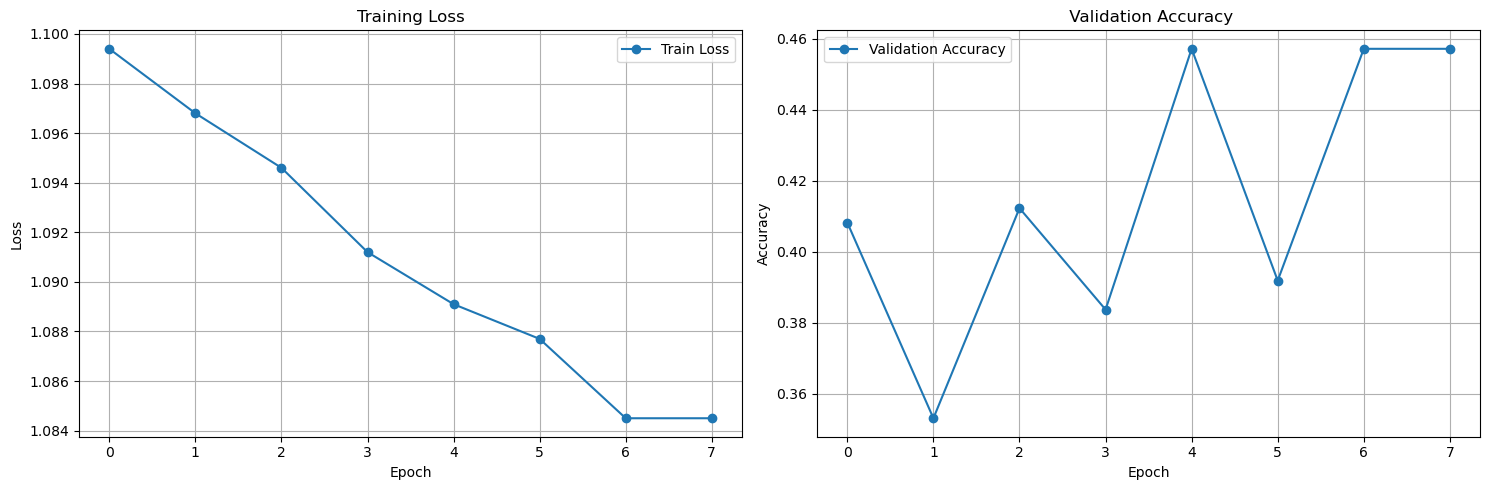


실험 시작: learning_rate=2e-05, batch_size=32


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.099400,1.096745,0.416327


In [ ]:
# 실험 실행
results = []
learning_rates = [2e-5, 5e-5, 1e-3]
batch_size_list = [16, 32]

for lr in learning_rates:
    for batch_size in batch_size_list:
        print(f"\n실험 시작: learning_rate={lr}, batch_size={batch_size}")
        result = model_experiments(lr, batch_size)
        results.append(result)  # 결과 저장

# 모든 실험이 끝난 후 결과 비교
# print("\n=== 모든 실험 결과 비교 ===")
# for result in results:
#     lr = result['learning_rate']
#     bs = result['batch_size']
#     final_loss = result['train_losses'][-1] if result['train_losses'] else 'N/A'
#     final_acc = result['eval_accuracies'][-1] if result['eval_accuracies'] else 'N/A'
    
#     print(f"\nlearning_rate={lr}, batch_size={bs}")
#     print(f"최종 학습 손실: {final_loss}")
#     print(f"최종 검증 정확도: {final_acc}")